In [1]:
import os
import copy
import math
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy.visualization import MinMaxInterval
from astropy.visualization import make_lupton_rgb #Uses a technique from https://arxiv.org/pdf/astro-ph/0312483.pdf 
#that allows RGB images to be created showing good detail while preventing loss of colour.

import keras.preprocessing.image
from keras.models import Sequential
from keras.utils import multi_gpu_model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Flatten
from keras.utils import to_categorical
from keras.layers.core import Dropout
from keras.layers.core import Reshape
import keras.optimizers

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
mainFitsFolder=os.getcwd()+"/CORNISH_FITS_I_SORTED"

#trainingObjectLabels=["Dark HII-Region","Diffuse HII-Region","Galaxy","HII-Region","IR-Quiet"
                      #,"Other","PN","Radio-Galaxy (Central Source)","Radio-Galaxy (Lobe)"
                      #,"Radio-Star","SNR","UCHII"]


#A map of object folder names to their object type
trainingObjectFolderLabelMap={"Dark HII-Region":"HII Region","Diffuse HII-Region":"HII Region"
                              ,"HII-Region":"HII Region","PN":"Planetary Nebula",
                              "Radio-Star":"Radio Star","UCHII":"HII Region"}

#A list of the possible object labels with no duplicates.
trainingObjectLabels=list(set(trainingObjectFolderLabelMap.values()))



testingFolder="testing"
fitsSuffixLength=8

trainingObjectTransformNumber=3 #Number of transformed copies (horizontal flips,
#vertical flips and rotation) of each training image to also create

imageSize=(302,302) #The size that all images are required to be by the CNN.
imageGeneratorBatchSize=32

#The minimum amount of black pixels connected into one region for the image to be
#designated as an edge image
edgeImageMinimumBlackArea=20

In [4]:
# Returns a list of all of the object names in a folder.
def getObjectNames(folder):
    objectNames=[]
    
    for fileName in os.listdir(folder):
        currentObjectName=fileName[:len(fileName)-fitsSuffixLength]
        
        if currentObjectName not in objectNames:
            objectNames.append(currentObjectName) #Adds a new name that hasn't previously been added to the list.
    
    return objectNames   



#Gets the four fit file paths for an imaged object, returns them if successfull
def getObjectFitsPaths(folder,objectName):
    fitsPaths=["","","",""]
 
    #for i in range(4,0,-1):
    for i in range(1,5):
        currentFitsPath=folder+"/"+objectName+"_I"+str(i)+".fits"

        if os.path.isfile(currentFitsPath):
            fitsPaths[4-i]=currentFitsPath # Uses 4-i to make sure they are in order from longest to shortest wavelength.
        else:
            fitsPaths=[]
            break
       
    return fitsPaths

# Class to hold named imaged objects

In [5]:
class ImagedObject:
    fitsPath=["","","",""]
    objectName=""
    objectType="Other" #Default type is "Other".
    transformImage=False #Whether the image is to be randomly transformed when generated.
    imageData=None
                
    def __init__(self,fitsPath,objectName,objectType,transformImage):
        self.fitsPath=copy.deepcopy(fitsPath)
        self.objectName=objectName
        self.objectType=objectType
        self.transformImage=transformImage 
        self.createImageData()
        
    def getImageData(self):      
        imageScaler=MinMaxInterval()      
        scaledImage=imageScaler(self.imageData) #The image is offsetted and scaled to the range 0 to 1.
        
        if self.transformImage:
            averageFilterValues=[np.average(scaledImage[:,:,0]),np.average(scaledImage[:,:,1]),np.average(scaledImage[:,:,2]),np.average(scaledImage[:,:,3])]
            imageBackground=np.zeros(shape=self.imageData.shape)
            
            for i in range(0,4): #The background values are given their correct values based on the filter layer.
                imageBackground[:,:,i]=np.full(self.imageData.shape[:2],averageFilterValues[i])
                
            imageBackgroundN=np.array(imageBackground)
            
            #The image has the background subtracted from it.
            scaledImage=np.subtract(scaledImage,imageBackgroundN)
    
            if random.getrandbits(1): #Vertical flip
                scaledImage=keras.preprocessing.image.flip_axis(scaledImage,0)
                
            if random.getrandbits(1): #Horizontal flip
                scaledImage=keras.preprocessing.image.flip_axis(scaledImage,1)
            
            scaledImage=keras.preprocessing.image.random_shift(scaledImage,0.2,0.2,row_axis=0,col_axis=1,channel_axis=2,fill_mode='constant')
            scaledImage=keras.preprocessing.image.random_rotation(scaledImage,360,row_axis=0,col_axis=1,channel_axis=2,fill_mode='constant')
            scaledImage=keras.preprocessing.image.random_zoom(scaledImage,(0.8,1.2),row_axis=0,col_axis=1,channel_axis=2,fill_mode='constant')  
            
            #The transformed image is added to the background; all parts on the image filled with 0 during
            #the transformation are now the background.
            scaledImage=np.add(scaledImage,imageBackgroundN) 
            
        return scaledImage   
    
    
    def createImageData(self):
        fitsFiles=[None,None,None,None]
        fitsFiles[0]=fits.open(self.fitsPath[0])
        fitsFiles[1]=fits.open(self.fitsPath[1])
        fitsFiles[2]=fits.open(self.fitsPath[2])
        fitsFiles[3]=fits.open(self.fitsPath[3])
            
        singleImageDimensions=fitsFiles[0][0].shape   
        imageDimensions=singleImageDimensions+(4,)
        self.imageData=np.empty(shape=imageDimensions,dtype=np.float32) #Holds all of the image data from all four filters in one list.
        
        for i in range(0,4):
            currentFits=fitsFiles[i]
            self.imageData[:,:,i]=currentFits[0].data
    
    def imageDataHasCorrectDimensions(self,requiredImageDimensions):
        for i in range(0,4):
            currentFitsFile=fits.open(self.fitsPath[0])
            
            if not (currentFitsFile[0].data.shape == requiredImageDimensions):
                return False       
        return True  
    
    
    #Detects if the image has large black sections coming in from the edges; if it does
    #the image is likely from the edge of the survey and should not be used.
    def imageIsLikelyFromEdge(self):       
        edgePixels=self.getEdgePixelList()
        traversedPixels=np.empty(shape=self.imageData.shape,dtype=np.bool_)

        for i in range(0,4):
            for j in edgePixels:
                    traversedPixels.fill(False)
                    contiguousPixelCount=0
                    if self.explorePixel(traversedPixels,j,i,contiguousPixelCount)==True:
                        return True
      
        return False
                    
                    
            
        
    def getEdgePixelList(self):
        topPixels=()
        bottomPixels=()
        leftPixels=()
        rightPixels=()
        
        for i in range(0,self.imageData.shape[0]):
            topPixels+=((i,0),)
            bottomPixels+=((i,self.imageData.shape[0]-1),)
            
        for i in range(0,self.imageData.shape[1]):
            leftPixels+=((0,i),)
            rightPixels+=((self.imageData.shape[1]-1,i),)


        #The set is used to remove any duplicates from the corners of the image.
        edgePixelSet=set(topPixels+bottomPixels+leftPixels+rightPixels)
        return list(edgePixelSet)
    
    '''Uses the flood fill algorithm (from https://en.wikipedia.org/wiki/Flood_fill, often used in art
    programs to change the colour of an area) to recursively count the amount of contiguous black pixels'''
    def explorePixel(self,traversedPixels,location,filterLayer,contiguousPixelCount):
        try:
            if traversedPixels[location+(filterLayer,)]==True:
                return False #This pixel has already been traversed.
            else:
                traversedPixels[location+(filterLayer,)]=True

        except IndexError:
            return False #It is trying to explore outside the boundaries of the image.
            
        #There are enough black pixels for the image to be considered an image with an edge.
        if contiguousPixelCount>=edgeImageMinimumBlackArea:    
            return True #This will propogate back to the imageIsLikelyFromEdge function
        
        if self.imageData[location+(filterLayer,)]==0.0: #The pixel is black
            contiguousPixelCount+=1
            
            upPixel=(location[0],location[1]+1)
            downPixel=(location[0],location[1]-1)
            leftPixel=(location[0]-1,location[1])
            rightPixel=(location[0]+1,location[1])   
        
            #Recursively explores neighbouring pixels and returns if any of thse pixels detect
            #the image to be an edge image 
            return self.explorePixel(traversedPixels,upPixel,filterLayer,contiguousPixelCount) or self.explorePixel(traversedPixels,downPixel,filterLayer,contiguousPixelCount) or self.explorePixel(traversedPixels,leftPixel,filterLayer,contiguousPixelCount) or self.explorePixel(traversedPixels,rightPixel,filterLayer,contiguousPixelCount)
        
        return False

In [7]:
#Adds a single ImagedObject and its transformations to a object list and returns if this could be done
def addImagedObjectToList(fitsPaths,objectName,objectType,imagedObjectList,numberOfTransformations):
    newImagedObject=ImagedObject(fitsPaths,objectName,objectType,False) 
    
    if not newImagedObject.imageDataHasCorrectDimensions(imageSize):
        print(objectName+" has incorrect image dimensions")
        return False
    
    if newImagedObject.imageIsLikelyFromEdge():
        print(objectName+" is likely an image from the edge of the survey")
        return False
    

    imagedObjectList.append(newImagedObject)
            
    for i in range(0,numberOfTransformations):
        transformedImageObject=ImagedObject(fitsPaths,objectName,objectType,True)
        imagedObjectList.append(transformedImageObject)
        
    return True



#Creates ImagedObjects from the contents from a particular folder.
def addImagedObjectsFromFolder(folder,imagedObjectType,imagedObjectList,numberOfTransformations):
    successfulProcessedObjects=0
    currentObjectNames=getObjectNames(folder)

    successfulyProcessedObject=0
    for currentObjectName in currentObjectNames:
        currentObjectFitsPaths=getObjectFitsPaths(folder,currentObjectName)

        if len(currentObjectFitsPaths)!=0:
            if addImagedObjectToList(currentObjectFitsPaths,currentObjectName,imagedObjectType,imagedObjectList,numberOfTransformations):       
                successfulProcessedObjects+=1
        else:
            print("Imaged object "+currentObjectName+" does not have four fits files accociated with it")
        
    print(str(successfulProcessedObjects)+" imaged objects of type "+imagedObjectType+" were correctly processed"+"\n")
    

# Creation of a list of imaged objects

In [8]:
#Adds the training and testing objects from their respective folders.
trainingObjects=[]
testingObjects=[]

for currentFolder in list(trainingObjectFolderLabelMap.keys()):
    currentObjectType=trainingObjectFolderLabelMap[currentFolder]
    print("Creating training objects of object type "+currentObjectType+" from folder "+currentFolder)
    addImagedObjectsFromFolder(mainFitsFolder+"/"+currentFolder,currentObjectType,trainingObjects,trainingObjectTransformNumber)
    

#print("Creating testing objects")
#addImagedObjectsFromFolder(mainFitsFolder+"/"+testingFolder,testingFolder,testingObjects,0)

Creating training objects of object type HII Region from folder Dark HII-Region
6 imaged objects of type HII Region were correctly processed

Creating training objects of object type HII Region from folder Diffuse HII-Region
G026.0907-00.0575 is likely an image from the edge of the survey
5 imaged objects of type HII Region were correctly processed

Creating training objects of object type HII Region from folder HII-Region
G049.4867-00.3800 is likely an image from the edge of the survey
G052.0991+01.0432 is likely an image from the edge of the survey
35 imaged objects of type HII Region were correctly processed

Creating training objects of object type Planetary Nebula from folder PN
G011.3266-00.3718 is likely an image from the edge of the survey
G011.4581+01.0736 is likely an image from the edge of the survey
G017.4147+00.3791 is likely an image from the edge of the survey
G024.0943-01.0992 is likely an image from the edge of the survey
G025.8466+01.1718 has incorrect image dimension

In [9]:
#A generator for the imaged objects used so not all images need to be loaded in memory.       
def imagedObjectGenerator(objectList,labelList,batchSize):
    currentBatchIndex=0
    currentImageData=[]
    currentImageLabels=[]
    
    objectListLength=len(objectList)
    currentObjectIndex=0
    while True: #The generator will continuesly generate imaged objects.
        currentImageData.append(objectList[currentObjectIndex].getImageData())
        currentImageLabels.append(labelList.index(objectList[currentObjectIndex].objectType))
        currentBatchIndex+=1
        
        if currentBatchIndex == batchSize:
            outputImageData=np.array(currentImageData)
            outputLabels=to_categorical(currentImageLabels,len(labelList))
            yield (outputImageData,outputLabels)
            currentBatchIndex=0
            currentImageData=[]
            currentImageLabels=[]
            
        currentObjectIndex+=1
        if currentObjectIndex >= objectListLength:
            currentObjectIndex=0 #Index loops back to the beginning of objectList

# CNN architecture

In [12]:
def createModelFromParameters(model,
                              convolutionalBlockCount,convolutionalInitalFilterCount,
                              convolutionalFilterCountMultiplier,convolutionalInitalFilterSize,
                              convolutionalFilterSizeDivisor,convolutionalInitalBlockLayerCount,
                              convolutionalBlockLayerMinuend,convolutionalDropout,  
                              denseLayerCount,denseInitalNeuronCount,denseNeuronCountDivisor,denseDropout):
    
    inputLayerExists=False
    
    #Convolutional section below 
    currentLayersPerBlock=convolutionalInitalBlockLayerCount
    currentFilterCount=convolutionalInitalFilterCount
    currentFilterSize=convolutionalInitalFilterSize
    for i in range(0,convolutionalBlockCount):
        for j in range(0,math.ceil(currentLayersPerBlock)):
            filterSizeTuple=(math.ceil(currentFilterSize),math.ceil(currentFilterSize))
            if not inputLayerExists:
                model.add(Conv2D(currentFilterCount,filterSizeTuple,padding="same",activation="relu",input_shape=(302,302,4)))
            else:
                model.add(Conv2D(currentFilterCount,filterSizeTuple,padding="same",activation="relu"))
                          
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(convolutionalDropout))
        currentLayersPerBlock-=convolutionalBlockLayerMinuend
        currentFilterCount*=convolutionalFilterCountMultiplier
        currentFilterSize/=convolutionalFilterSizeDivisor
        

    #Dense section and output below      
    model.add(Flatten())
    
    currentNeuronCount=denseInitalNeuronCount
    for i in range(0,denseLayerCount):
        if not inputLayerExists:
            model.add(Dense(math.ceil(currentNeuronCount),activation='relu',input_shape=(302,302,4)))
        else:
            model.add(Dense(math.ceil(currentNeuronCount),activation='relu'))
        model.add(Dropout(denseDropout))
        currentNeuronCount/=denseNeuronCountDivisor #Less neurons are in each successive dense layer.
        
    
    model.add(Dense(len(trainingObjectLabels),activation="softmax"))  

# Model setup

In [13]:
testModel=Sequential()

createModelFromParameters(model=testModel,
                         convolutionalBlockCount=3
                          ,convolutionalInitalFilterCount=32
                          ,convolutionalFilterCountMultiplier=2
                          ,convolutionalInitalFilterSize=10
                          ,convolutionalFilterSizeDivisor=2
                          ,convolutionalInitalBlockLayerCount=3
                          ,convolutionalBlockLayerMinuend=0.5
                          ,convolutionalDropout=0.2
                          ,denseLayerCount=2
                          ,denseInitalNeuronCount=256,
                          denseNeuronCountDivisor=4,
                          denseDropout=0.35)


np.random.shuffle(trainingObjects)
trainingImages=trainingObjects[::2]
testingImages=trainingObjects[1::2]

trainingGenerator=imagedObjectGenerator(trainingImages,trainingObjectLabels,imageGeneratorBatchSize)
testingGenerator=imagedObjectGenerator(testingImages,trainingObjectLabels,imageGeneratorBatchSize)
stepsPerEpoch=int(len(trainingImages)/imageGeneratorBatchSize)
validationSteps=int(len(testingImages)/imageGeneratorBatchSize)

#multiGpuModel=multi_gpu_model(model,gpus=2)
testModel.compile(optimizer=keras.optimizers.Adadelta(),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
modelFitHistory=testModel.fit_generator(trainingGenerator,steps_per_epoch=stepsPerEpoch,validation_data=testingGenerator,validation_steps=validationSteps,epochs=75,verbose=1)

Epoch 1/75
 3/35 [=>............................] - ETA: 7:46 - loss: 1.0842 - acc: 0.4167 

KeyboardInterrupt: 

In [39]:
testModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 302, 302, 32)      12832     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 302, 302, 32)      102432    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 302, 302, 32)      102432    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 151, 151, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 151, 151, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 151, 151, 64)      51264     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 151, 151, 64)      102464    
__________

# Accuracy plot viewer

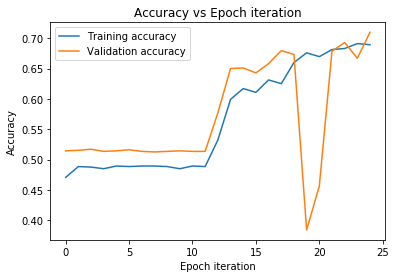

In [15]:
plt.plot(modelFitHistory.history["acc"],label="Training accuracy")
plt.plot(modelFitHistory.history["val_acc"],label="Validation accuracy")
plt.title("Accuracy vs Epoch iteration")
plt.xlabel("Epoch iteration")
plt.ylabel("Accuracy")
plt.legend(loc="best")
#plt.show()
plt.savefig("graph.png")

# Testing image prediction

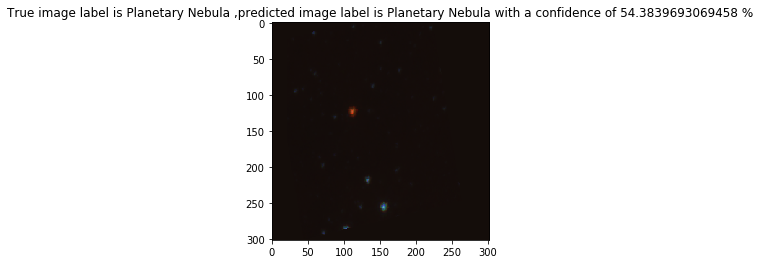

In [32]:
imageIndexToPredict=np.random.randint(0,len(testingImages))
imageObjectToPredict=testingImages[imageIndexToPredict]
trueImageLabel=imageObjectToPredict.objectType

imageListToPredictOn=[]
imageDataToPredictOn=imageObjectToPredict.getImageData()
imageListToPredictOn.append(imageDataToPredictOn)
imageLabelPrediction=testModel.predict_classes(np.array(imageListToPredictOn))[0]
imageLabelPredictionConfidence=np.amax(testModel.predict(np.array(imageListToPredictOn)))

plt.imshow(make_lupton_rgb(imageDataToPredictOn[:,:,0],imageDataToPredictOn[:,:,1],imageDataToPredictOn[:,:,2],stretch=0.2))
plt.title("True image label is "+trueImageLabel+" ,predicted image label is "+trainingObjectLabels[imageLabelPrediction]+" with a confidence of "+str(100*imageLabelPredictionConfidence)+" %")
plt.show()

# View individual image

G044.4228+00.5377


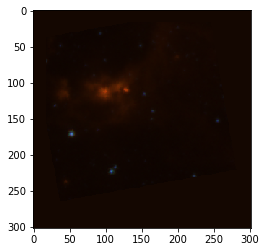

In [15]:
trainingObjectIndex=761
imageData=trainingObjects[trainingObjectIndex].getImageData()
print(trainingObjects[trainingObjectIndex].objectName)

plt.imshow(make_lupton_rgb(imageData[:,:,0],imageData[:,:,1],imageData[:,:,2],stretch=0.2))
plt.show()
#plt.savefig("hII.png")

# View weights of convolution filter

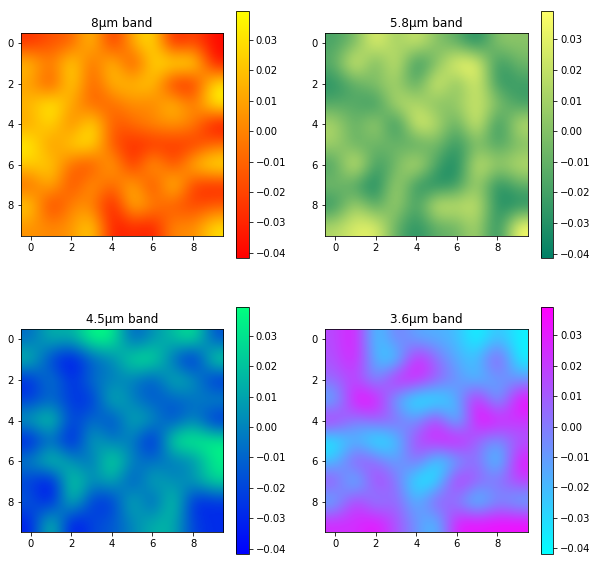

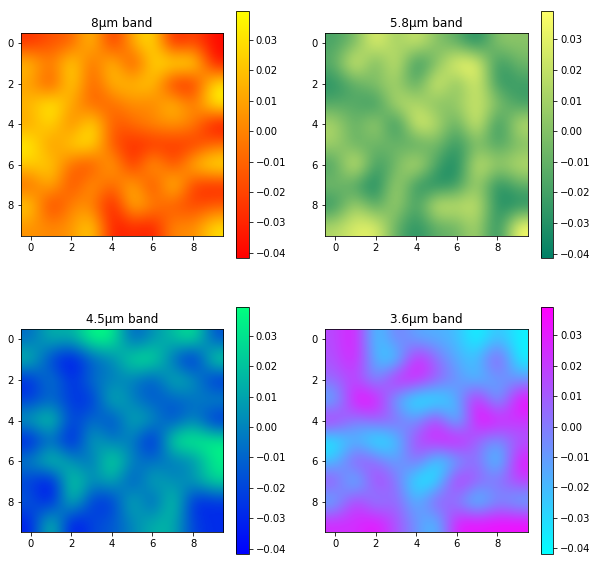

In [17]:
layerNumber=0
filterNumber=5

layerParameters=testModel.layers[layerNumber].get_weights()
layerWeights=layerParameters[0] #layerParameters[1] are the bias values.
filterValues=layerWeights[:,:,:,filterNumber]



plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(filterValues[:,:,0],cmap='autumn',interpolation='bicubic')
plt.title("8μm band")
plt.colorbar()

plt.subplot(222)

plt.imshow(filterValues[:,:,1],cmap='summer',interpolation='bicubic')
plt.title("5.8μm band")
plt.colorbar()

plt.subplot(223)

plt.imshow(filterValues[:,:,2],cmap='winter',interpolation='bicubic')
plt.title("4.5μm band")
plt.colorbar()

plt.subplot(224)

plt.imshow(filterValues[:,:,3],cmap='cool',interpolation='bicubic')
plt.title("3.6μm band")
plt.colorbar()

plt.show()
#plt.savefig("filterWeights.png")